In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.2.2 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [3]:
train = pd.read_csv('train_2016_v2.csv',parse_dates=['transactiondate'])
prop = pd.read_csv("properties_2016.csv")

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
prop.rename(columns={'yearbuilt':"build_year",
"basementsqft":"area_basement","yardbuildingsqft17":"area_patio",
"yardbuildingsqft26":"area_shed","poolsizesum":"area_pool",
'lotsizesquarefeet':"area_lot",'garagetotalsqft':"area_garage",
"finishedfloor1squarefeet":"area_firstfloor_finished",
"calculatedfinishedsquarefeet":"area_total_calc",
"finishedsquarefeet6":"area_base","finishedsquarefeet12":"area_live_finished",
"finishedsquarefeet13":"area_liveperi_finished",
"finishedsquarefeet15":"area_total_finished",
"finishedsquarefeet50":"area_entryfloor_finished","unitcnt":"num_unit",
"numberofstories":"num_story","roomcnt":"num_room",
"bathroomcnt":"num_bathroom",'bedroomcnt':"num_bedroom",
"calculatedbathnbr":"num_bathroom_calc","fullbathcnt":"num_bath",
"threequarterbathnbr":"num_75_bath","fireplacecnt":"num_fireplace",
"poolcnt":"num_pool","garagecarcnt":"num_garage","regionidcounty":"region_county",
"regionidcity":"region_city","regionidzip":"region_zip",
"regionidneighborhood":"region_neighbor",'taxvaluedollarcnt':"tax_total",
"structuretaxvaluedollarcnt":"tax_building","landtaxvaluedollarcnt":"tax_land",
"taxamount":"tax_property","assessmentyear":"tax_year","taxdelinquencyflag": "tax_delinquency",
"taxdelinquencyyear":"tax_delinquency_year","propertyzoningdesc":"zoning_property",
"propertylandusetypeid":"zoning_landuse","propertycountylandusecode":"zoning_landuse_county",
"fireplaceflag":"flag_fireplace","hashottuborspa":"flag_tub",
"buildingqualitytypeid":"quality","buildingclasstypeid":"framing",
"typeconstructiontypeid":"material","decktypeid":"deck","storytypeid":"story",
"heatingorsystemtypeid":"heating","airconditioningtypeid":"aircon",
"architecturalstyletypeid":"architectural_style"
},inplace=True)

Distribution of transaction dates
As shown in the figure above, there are only some of the transactions after 25.10 in the train set, because the rest is in the test set (for the public LB).

In [5]:
train['month'] = train['transactiondate'].dt.month
train['day'] = train['transactiondate'].dt.day

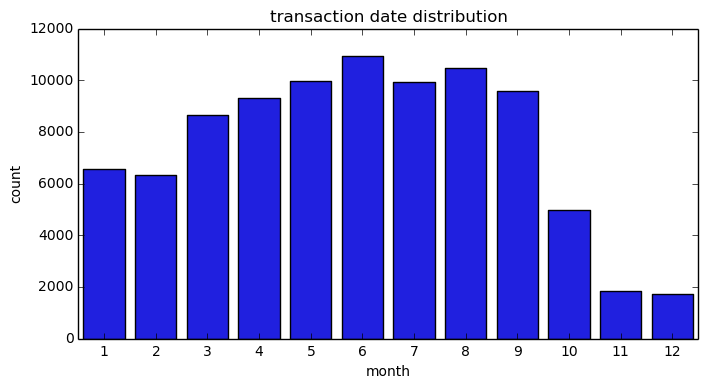

In [56]:
x = train.groupby(['month'],as_index=False)['day'].count()
plt.figure(figsize=(8,4))
sns.barplot(x['month'],x['day'],color='blue')
plt.ylabel("count")
plt.title("transaction date distribution")

Outcome

To get a feel for the data let’s first have a look at the distribution of our outcome (logerror), i.e. the difference in log(Zestimate)-log(Saleprice)

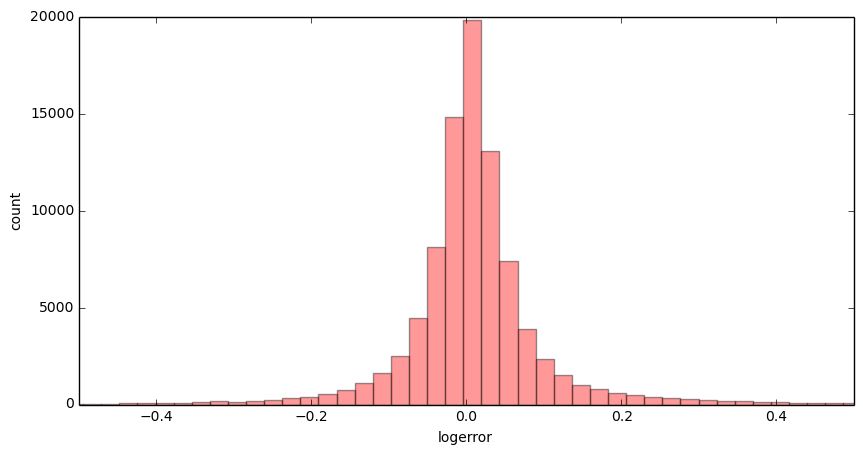

In [54]:
plt.figure(figsize=(10,5))
sns.distplot(train.logerror,kde=False,bins=400,color='red')
plt.xlim(-0.5,0.5)
plt.ylabel("count")

How does absolute log error change with time

There seems to be a light trend that Zestimates error decreases over time. Predictions are getting better. Zillow seems to have good data scientists :-).

In [6]:
train['abs_logerror'] = train.logerror.apply(lambda x: abs(x))

In [58]:
train.head(2)

,parcelid,logerror,transactiondate,month,day,abs_logerror
0,11016594,0.0276,2016-01-01,1,1,0.0276
1,14366692,-0.1684,2016-01-01,1,1,0.1684


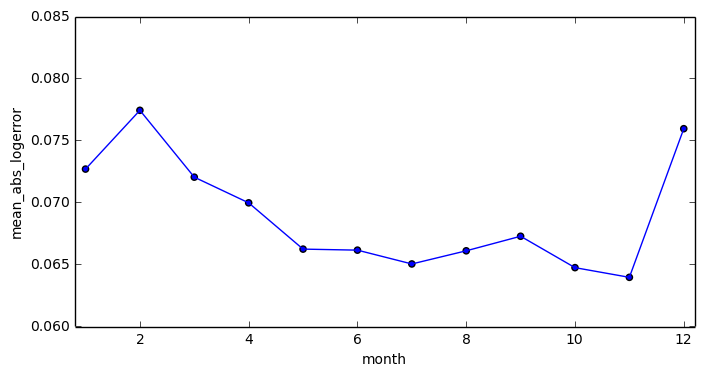

In [122]:
x = train.groupby(['month'],as_index=False)['abs_logerror'].mean()
plt.figure(figsize=(8,4))
plt.scatter(x.month,x.abs_logerror)
plt.plot(x.month,x.abs_logerror)
plt.xlim(0.8,12.2)
plt.xlabel("month")
plt.ylabel("mean_abs_logerror")

Missing values

We have seen many missing values in the data peeking. How many missing values are there for each feature? In fact, some features are missing nearly completely. So, we probably have to work more with the others.

In [65]:
prop.isnull().any()

parcelid                    False
aircon                       True
architectural_style          True
area_basement                True
num_bathroom                 True
num_bedroom                  True
framing                      True
quality                      True
num_bathroom_calc            True
deck                         True
area_firstfloor_finished     True
area_total_calc              True
area_live_finished           True
area_liveperi_finished       True
area_total_finished          True
area_entryfloor_finished     True
area_base                    True
fips                         True
num_fireplace                True
num_bath                     True
num_garage                   True
area_garage                  True
flag_tub                     True
heating                      True
latitude                     True
longitude                    True
area_lot                     True
num_pool                     True
area_pool                    True
pooltypeid10  

(-0.1, 1.1)

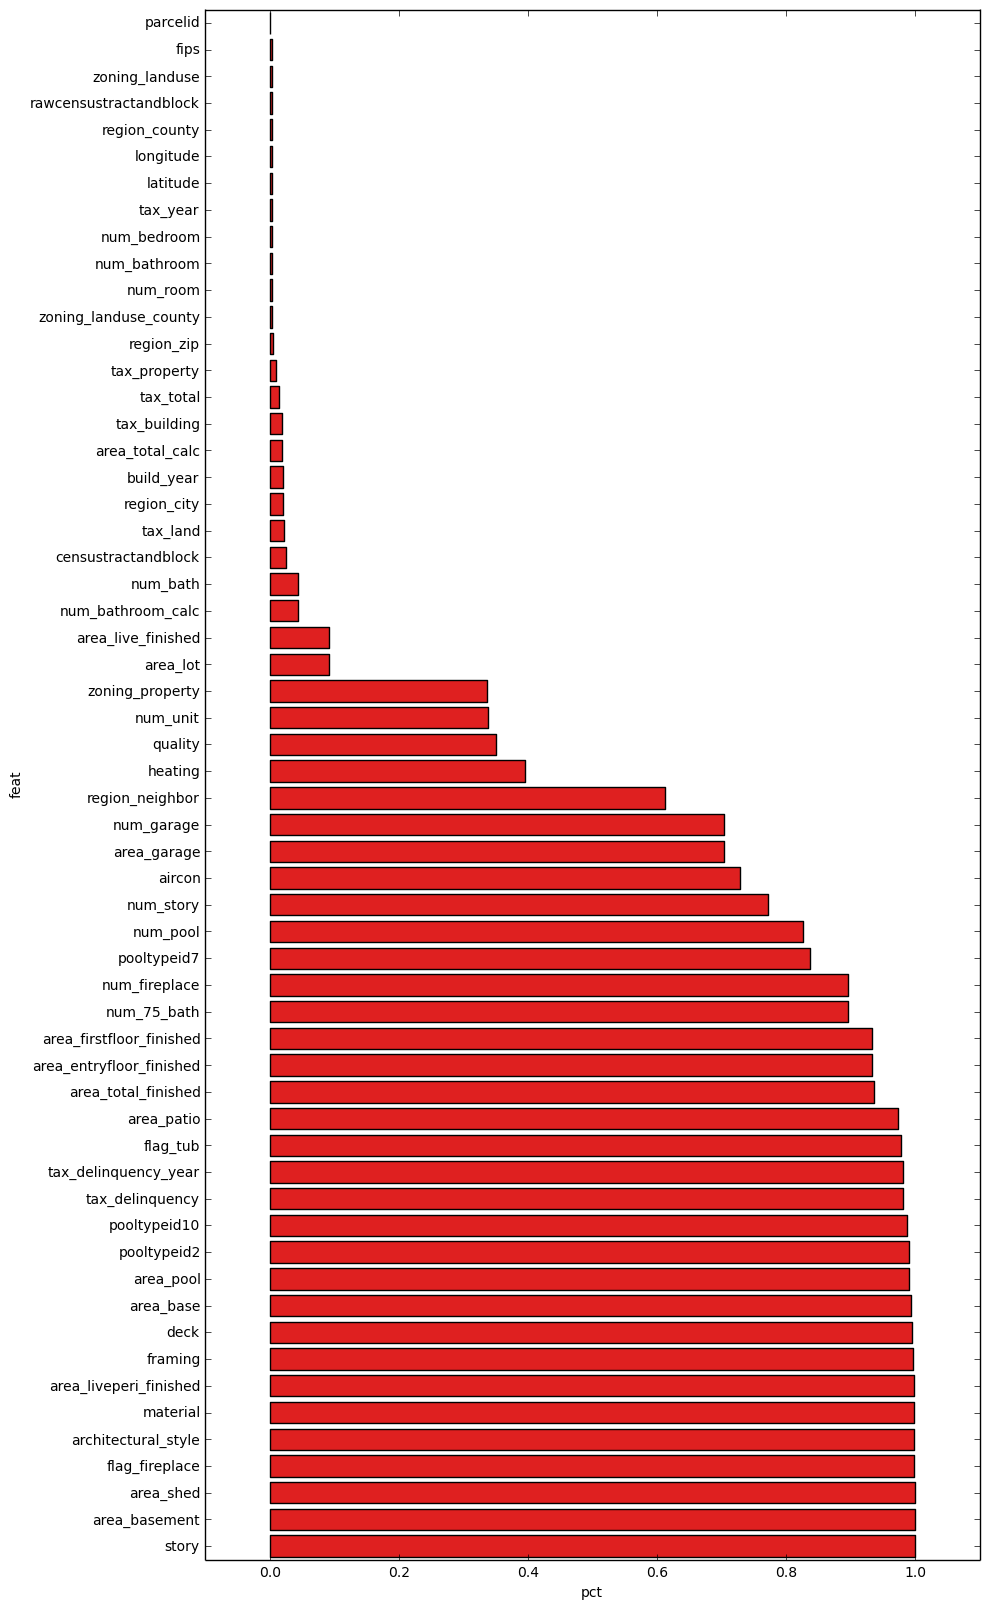

In [83]:
x = prop.isnull().sum(axis=0).sort_values().reset_index().rename(columns={'index':'feat',0:'missing_values'})
x['pct']=x['missing_values']/float(len(prop))
plt.figure(figsize=(10,20))
sns.barplot(x.pct,x.feat,color='red')
plt.xlim(-0.1,1.1)

In [89]:
good_features = x[x['pct']<0.75].feat.values

Correlation with absolute logerror

num_ features:

In [231]:
train_df = train.merge(prop[good_features],left_on='parcelid',right_on='parcelid')

In [113]:
num_feats = np.append(prop[good_features].filter(like="num").columns.values,['abs_logerror'])

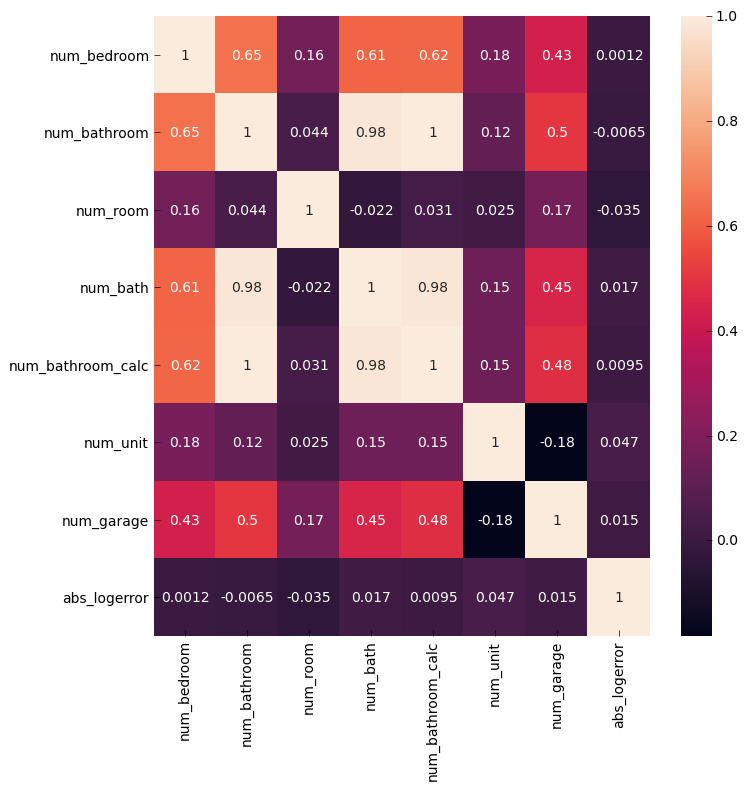

In [116]:
corr = train_df[num_feats].corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr,annot=True)

When were the houses built?

Let’s plot the distribution of build year for the houses. Most houses were built around 1950. There are not many older houses, neither many new houses >2000.

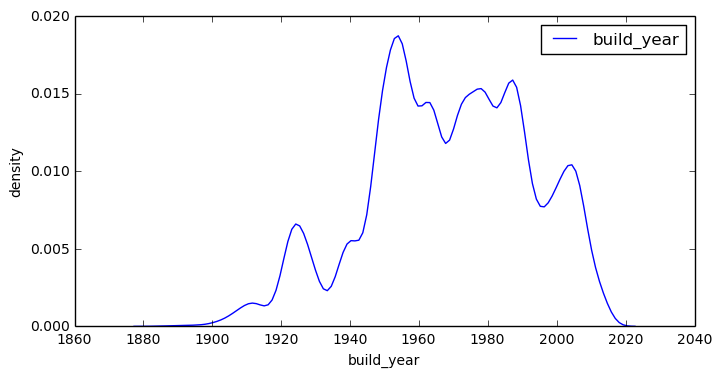

In [121]:
plt.figure(figsize=(8,4))
sns.kdeplot(train_df['build_year'])
plt.ylabel("density")
plt.xlabel("build_year")

How does the absolute logerror change with build_year?

Predictions are better for newer houses. As we saw in the figure above we have way fewer older houses. However, what is interesting is that there are many houses with build year around 1950, but predictions for those houses are not too good.

(0, 0.25)

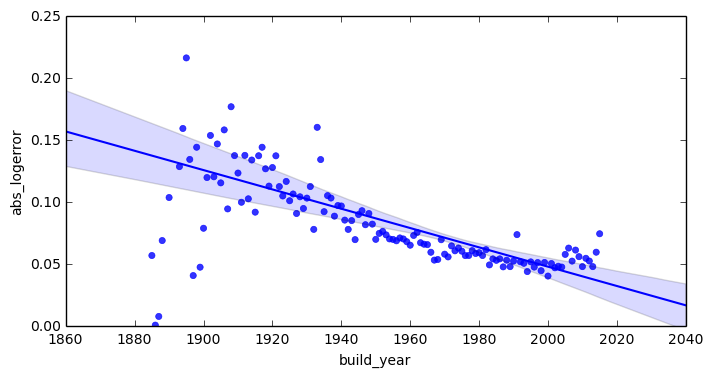

In [125]:
x = train_df.groupby(['build_year'],as_index=False)['abs_logerror'].mean()
plt.figure(figsize=(8,4))
sns.regplot(x['build_year'],x['abs_logerror'])
plt.ylim(0,0.25)

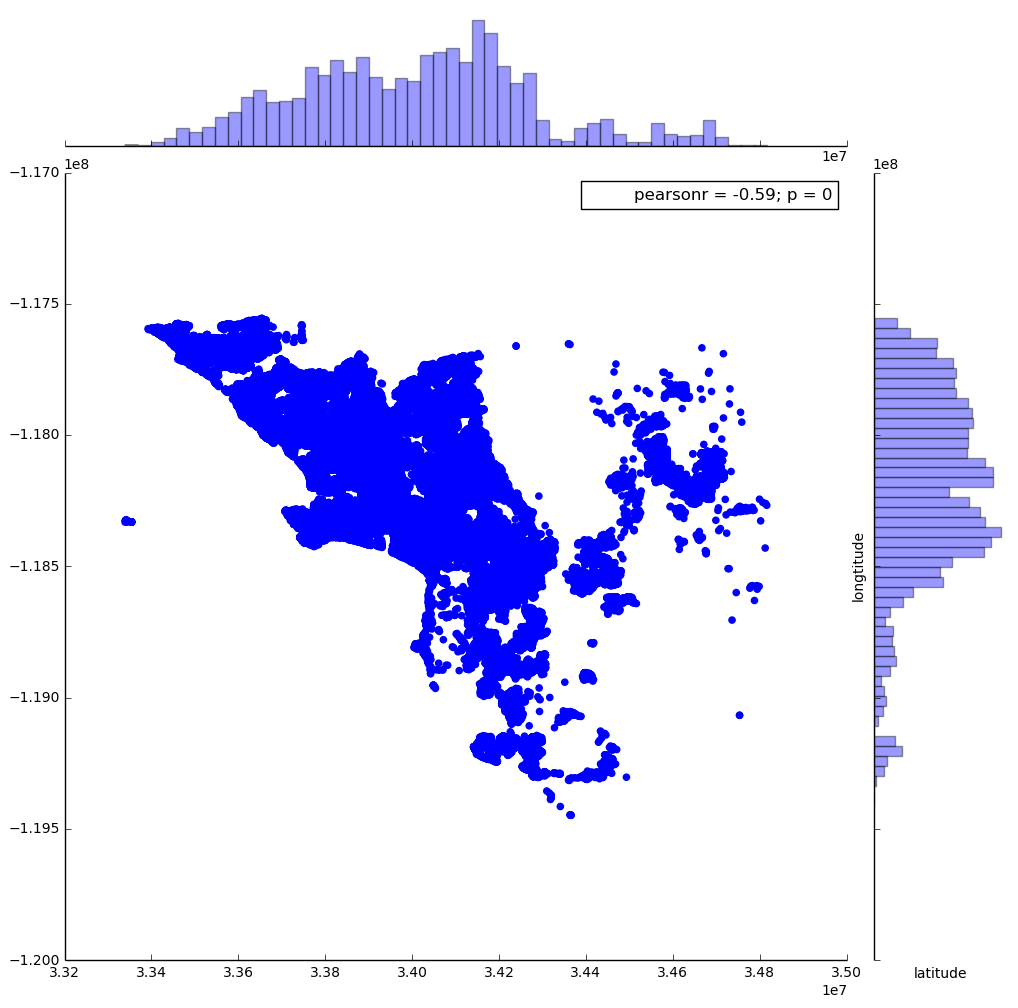

In [126]:
plt.figure(figsize=(12,12))
sns.jointplot(train_df['latitude'].values,train_df['longitude'].values,size=10)
plt.ylabel('longtitude')
plt.xlabel("latitude")

## train

In [24]:
print "importing libs"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectFromModel
%matplotlib inline

importing libs


In [2]:
print "parsing train and prop tables"
train = pd.read_csv('train_2016_v2.csv',parse_dates=['transactiondate'])
prop = pd.read_csv("properties_2016.csv")
train['month'] = train['transactiondate'].dt.month
train['day'] = train['transactiondate'].dt.day
print "renaming the columns"
prop.rename(columns={'yearbuilt':"build_year",
"basementsqft":"area_basement","yardbuildingsqft17":"area_patio",
"yardbuildingsqft26":"area_shed","poolsizesum":"area_pool",
'lotsizesquarefeet':"area_lot",'garagetotalsqft':"area_garage",
"finishedfloor1squarefeet":"area_firstfloor_finished",
"calculatedfinishedsquarefeet":"area_total_calc",
"finishedsquarefeet6":"area_base","finishedsquarefeet12":"area_live_finished",
"finishedsquarefeet13":"area_liveperi_finished",
"finishedsquarefeet15":"area_total_finished",
"finishedsquarefeet50":"area_entryfloor_finished","unitcnt":"num_unit",
"numberofstories":"num_story","roomcnt":"num_room",
"bathroomcnt":"num_bathroom",'bedroomcnt':"num_bedroom",
"calculatedbathnbr":"num_bathroom_calc","fullbathcnt":"num_bath",
"threequarterbathnbr":"num_75_bath","fireplacecnt":"num_fireplace",
"poolcnt":"num_pool","garagecarcnt":"num_garage","regionidcounty":"region_county",
"regionidcity":"region_city","regionidzip":"region_zip",
"regionidneighborhood":"region_neighbor",'taxvaluedollarcnt':"tax_total",
"structuretaxvaluedollarcnt":"tax_building","landtaxvaluedollarcnt":"tax_land",
"taxamount":"tax_property","assessmentyear":"tax_year","taxdelinquencyflag": "tax_delinquency",
"taxdelinquencyyear":"tax_delinquency_year","propertyzoningdesc":"zoning_property",
"propertylandusetypeid":"zoning_landuse","propertycountylandusecode":"zoning_landuse_county",
"fireplaceflag":"flag_fireplace","hashottuborspa":"flag_tub",
"buildingqualitytypeid":"quality","buildingclasstypeid":"framing",
"typeconstructiontypeid":"material","decktypeid":"deck","storytypeid":"story",
"heatingorsystemtypeid":"heating","airconditioningtypeid":"aircon",
"architecturalstyletypeid":"architectural_style"
},inplace=True)


x = prop.isnull().sum(axis=0).sort_values().reset_index().rename(columns={'index':'feat',0:'missing_values'})
x['pct']=x['missing_values']/float(len(prop))

good_features = x[x['pct']<0.95].feat.values
print "good features are: ", good_features

train_df = train.merge(prop[good_features],left_on='parcelid',right_on='parcelid')
del train
del prop
print "shape of train_df: ", train_df.shape

parsing train and prop tables


/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


renaming the columns
good features are:  ['parcelid' 'fips' 'zoning_landuse' 'rawcensustractandblock'
 'region_county' 'longitude' 'latitude' 'tax_year' 'num_bedroom'
 'num_bathroom' 'num_room' 'zoning_landuse_county' 'region_zip'
 'tax_property' 'tax_total' 'tax_building' 'area_total_calc' 'build_year'
 'region_city' 'tax_land' 'censustractandblock' 'num_bath'
 'num_bathroom_calc' 'area_live_finished' 'area_lot' 'zoning_property'
 'num_unit' 'quality' 'heating' 'region_neighbor' 'num_garage'
 'area_garage' 'aircon' 'num_story' 'num_pool' 'pooltypeid7'
 'num_fireplace' 'num_75_bath' 'area_firstfloor_finished'
 'area_entryfloor_finished' 'area_total_finished']
shape of train_df:  (90275, 45)


In [3]:
train_df.isnull().any()

parcelid                    False
logerror                    False
transactiondate             False
month                       False
day                         False
fips                        False
zoning_landuse              False
rawcensustractandblock      False
region_county               False
longitude                   False
latitude                    False
tax_year                    False
num_bedroom                 False
num_bathroom                False
num_room                    False
zoning_landuse_county        True
region_zip                   True
tax_property                 True
tax_total                    True
tax_building                 True
area_total_calc              True
build_year                   True
region_city                  True
tax_land                     True
censustractandblock          True
num_bath                     True
num_bathroom_calc            True
area_live_finished           True
area_lot                     True
zoning_propert

In [3]:
train_df.drop(['parcelid','transactiondate'],inplace=True,axis=1)
train_df=train_df[ train_df.logerror > -0.4 ]
train_df=train_df[ train_df.logerror < 0.419 ]

In [12]:
train_df.shape

(88528, 40)

In [233]:
##### columns with only one unique value

In [4]:
cols_one_value = []
for c in train_df.columns:
    num = len(train_df[c].unique())
    if num==1:
        cols_one_value.append(c)

In [5]:
cols_one_value

['tax_year']

In [6]:
train_df.drop(cols_one_value,inplace=True,axis=1)

In [7]:
train_df.drop(['zoning_landuse_county'],axis=1,inplace=True)

In [8]:
train_df.drop(['pooltypeid7'],axis=1,inplace=True)

In [238]:
#### cat features

In [9]:
cat_features = []
for c in train_df.columns:
    num = len(train_df[c].unique())
    if num<2000 and 'num' not in c and 'area' not in c and c not in ['build_year','month','day','logerror']:
        cat_features.append(c)

In [10]:
cat_features

['fips',
 'zoning_landuse',
 'region_county',
 'region_zip',
 'region_city',
 'zoning_property',
 'quality',
 'heating',
 'region_neighbor',
 'aircon']

In [241]:
### LabelEncoder cat features

In [11]:
train_df['zoning_landuse'].unique()

array([261., 266., 265., 246., 263., 269., 248., 247., 267., 275., 260.,
        31., 264.])

In [12]:
for c in cat_features:
    if c is not "zoning_property":
        train_df[c]=train_df[c].fillna(-1)
    else:
        train_df[c]=train_df[c].fillna("NNNNN")
    lbl = LabelEncoder()
    lbl.fit(list(train_df[c].unique()))
    train_df[c]=lbl.transform(train_df[c])
    print c

fips
zoning_landuse
region_county
region_zip
region_city
zoning_property
quality
heating
region_neighbor
aircon


In [ ]:
### standardscale numeric features

In [14]:
train_df.dtypes

logerror                    float64
month                         int64
day                           int64
fips                          int64
zoning_landuse                int64
rawcensustractandblock      float64
region_county                 int64
longitude                   float64
latitude                    float64
num_bedroom                 float64
num_bathroom                float64
num_room                    float64
region_zip                    int64
tax_property                float64
tax_total                   float64
tax_building                float64
area_total_calc             float64
build_year                  float64
region_city                   int64
tax_land                    float64
censustractandblock         float64
num_bath                    float64
num_bathroom_calc           float64
area_live_finished          float64
area_lot                    float64
zoning_property               int64
num_unit                    float64
quality                     

In [16]:
"""
for c in train_df.columns:
    train_df[c] = train_df[c].fillna(train_df[c].mean())
    if c != 'logerror' and c not in cat_features:
        scaler = StandardScaler()
        train_df[c] = scaler.fit_transform(train_df[c])
        print c
"""

month
day
rawcensustractandblock
longitude
latitude
num_bedroom
num_bathroom
num_room
tax_property
tax_total
tax_building
area_total_calc
build_year
tax_land
censustractandblock
num_bath
num_bathroom_calc
area_live_finished
area_lot
num_unit
num_garage
area_garage
num_story
num_pool
num_fireplace
num_75_bath
area_firstfloor_finished
area_entryfloor_finished
area_total_finished


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preproc

In [15]:
for c in cat_features:
    print c, len(train_df[c].unique())

fips 3
zoning_landuse 13
region_county 3
region_zip 389
region_city 178
zoning_property 1972
quality 9
heating 13
region_neighbor 495
aircon 7


In [20]:
"""
from sklearn.preprocessing import OneHotEncoder
encoded_x = None
for c in cat_features:
    if True:#c not in ['region_zip','region_city','zoning_property','region_neighbor']:
        onehot = OneHotEncoder(sparse=False)
        feature = onehot.fit_transform(train_df[c].reshape(len(train_df[c]),1))
        if encoded_x is None:
            encoded_x = feature
        else:
            encoded_x = np.concatenate((encoded_x, feature), axis=1)
        print c
"""

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


fips
zoning_landuse
region_county
region_zip
region_city
zoning_property
quality
heating
region_neighbor
aircon


In [21]:
encoded_x.shape

(88528, 3082)

In [22]:
"""
scaled_x = None
for c in train_df.columns:
    if c != 'logerror' and c not in cat_features:#["fips",'zoning_landuse','region_county','quality','heating','aircon']:
        feature = train_df[c].reshape(len(train_df[c]),1)
        if scaled_x is None:
            scaled_x = feature
        else:
            scaled_x = np.concatenate((scaled_x, feature), axis=1)
        print c
"""

month
day
rawcensustractandblock
longitude
latitude
num_bedroom
num_bathroom
num_room
tax_property
tax_total
tax_building
area_total_calc
build_year
tax_land
censustractandblock
num_bath
num_bathroom_calc
area_live_finished
area_lot
num_unit
num_garage
area_garage
num_story
num_pool
num_fireplace
num_75_bath
area_firstfloor_finished
area_entryfloor_finished
area_total_finished


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [23]:
scaled_x.shape

(88528, 29)

In [16]:
train_df.head(2)

,logerror,month,day,fips,zoning_landuse,rawcensustractandblock,region_county,longitude,latitude,num_bedroom,...,num_garage,area_garage,aircon,num_story,num_pool,num_fireplace,num_75_bath,area_firstfloor_finished,area_entryfloor_finished,area_total_finished
0,0.0276,1,1,0,5,6.037107e+07,2,-118488536.0,34280990.0,3.0,...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.1684,1,1,1,5,6.059052e+07,0,-117677556.0,33668120.0,4.0,...,2.0,468.0,0,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [17]:
from sklearn.cross_validation import train_test_split
x = train_df.drop(['logerror'],axis=1)
y = train_df['logerror']
#x = np.concatenate((scaled_x,encoded_x),axis=1)
#y = train_df.logerror
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [18]:
y_mean = np.mean(y_train)

In [23]:
print("\nSetting up data for XGBoost ...")
xgb_params = {
    'silent':1,
    'eta':0.033,
    'max_depth':6,
    #'min_child_weight':1,
    "subsample":0.8,
    #'colsample_bytree':0.8,
    'objective':"reg:linear",
    "eval_metric":"mae",
    "base_score":y_mean   
}
dtrain = xgb.DMatrix(x_train,y_train)
num_boost_rounds = 1000
print("num_boost_rounds="+str(num_boost_rounds))
cvresults = xgb.cv(xgb_params,dtrain,num_boost_round=num_boost_rounds,nfold=5,shuffle=True,show_stdv=False,metrics="mae",early_stopping_rounds=50)
print("n_estimators: ", cvresults.shape[0])
print cvresults




Setting up data for XGBoost ...
num_boost_rounds=1000
('n_estimators: ', 146)
     test-mae-mean  test-mae-std  train-mae-mean  train-mae-std
0         0.053506      0.000390        0.053488       0.000097
1         0.053475      0.000386        0.053440       0.000099
2         0.053442      0.000384        0.053392       0.000097
3         0.053411      0.000381        0.053343       0.000098
4         0.053386      0.000381        0.053298       0.000101
5         0.053361      0.000383        0.053256       0.000101
6         0.053339      0.000383        0.053216       0.000099
7         0.053319      0.000381        0.053180       0.000100
8         0.053296      0.000380        0.053143       0.000101
9         0.053277      0.000379        0.053108       0.000099
10        0.053258      0.000375        0.053075       0.000099
11        0.053239      0.000377        0.053042       0.000100
12        0.053221      0.000378        0.053010       0.000101
13        0.053206      0

In [36]:
#RMSE:  0.052149
# train model
print( "\nTraining XGBoost ...")
model = xgb.XGBRegressor( learning_rate =0.033, n_estimators=cvresults.shape[0], max_depth=6, 
                                    subsample=0.8, objective= "reg:linear")
model.fit(x_train,y_train)
print( "\nPredicting with XGBoost ...")
xgb_pred1 = model.predict(x_test)
score = mean_absolute_error(y_test,xgb_pred1)
print "MAE: ",score

#feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
#feat_imp.plot(kind='bar', title='Feature Importances')
#plt.ylabel('Feature Importance Score')


Training XGBoost ...

Predicting with XGBoost ...
MAE:  0.05214939203247517


In [29]:
"""
y_pred = []
for i,predict in enumerate(xgb_pred1):
    y_pred.append(str(round(predict,4)))

y_pred = np.array(y_pred)

y_pred

output = pd.DataFrame({'ParcelId': prop['parcelid'].astype(np.int32),
        '201610': y_pred, '201611': y_pred, '201612': y_pred,
        '201710': y_pred, '201711': y_pred, '201712': y_pred})
"""

In [1]:
#RMSE:  0.08168117762245547
'''
selection = SelectFromModel(model,prefit=True)
select_X_train = selection.transform(x_train)
select_X_test = selection.transform(x_test)
# train model
print( "\nTraining XGBoost ...")
selected_model = model#xgb.XGBRegressor( learning_rate =0.1, n_estimators=cvresults.shape[0], max_depth=5,min_child_weight=1, 
         #                          gamma=0, subsample=0.8, colsample_bytree=0.8, objective= "reg:linear")
selected_model.fit(select_X_train,y_train)
print( "\nPredicting with XGBoost ...")
xgb_pred2 = selected_model.predict(select_X_test)
score = mean_absolute_error(y_test,xgb_pred2)
print "MAE: ",score
'''


'\nselection = SelectFromModel(model,prefit=True)\nselect_X_train = selection.transform(x_train)\nselect_X_test = selection.transform(x_test)\n# train model\nprint( "\nTraining XGBoost ...")\nselected_model = model#xgb.XGBRegressor( learning_rate =0.1, n_estimators=cvresults.shape[0], max_depth=5,min_child_weight=1, \n         #                          gamma=0, subsample=0.8, colsample_bytree=0.8, objective= "reg:linear")\nselected_model.fit(select_X_train,y_train)\nprint( "\nPredicting with XGBoost ...")\nxgb_pred2 = selected_model.predict(select_X_test)\nscore = mean_absolute_error(y_test,xgb_pred2)\nprint "MAE: ",score\n'

In [390]:
"""
thresholds = sorted(model.feature_importances_)

for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model,prefit=True)
    select_X_train = selection.transform(x_train)
    select_X_test = selection.transform(x_test)
    # train model
    selection_model = xgb.XGBRegressor( learning_rate =0.1, n_estimators=cvresults.shape[0], max_depth=5,min_child_weight=1, 
                             gamma=0, subsample=0.8, colsample_bytree=0.8, objective= "reg:linear")
    selection_model.fit(select_X_train, y_train)
    # eval model
    y_pred = selection_model.predict(select_X_test)
    score = np.sqrt(mean_squared_error(y_test,y_pred))
    print thresh, score
"""

0.0 0.0824518114659547
0.0 0.0824518114659547
0.0 0.0824518114659547
0.0 0.0824518114659547


KeyboardInterrupt: 

In [331]:
from sklearn.model_selection import GridSearchCV
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=74, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= "reg:linear", seed=27), 
 param_grid = param_test1, scoring='neg_mean_squared_error',iid=False, cv=5)
gsearch1.fit(x_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.00680, std: 0.00010, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.00681, std: 0.00010, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.00680, std: 0.00010, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.00678, std: 0.00009, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.00678, std: 0.00010, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.00679, std: 0.00009, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.00680, std: 0.00010, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -0.00680, std: 0.00010, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.00679, std: 0.00010, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -0.00683, std: 0.00009, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: -0.00681, std: 0.00009, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: -0.00680, std: 0.00008, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_chil

In [ ]:
#one step deeper

In [332]:
from sklearn.model_selection import GridSearchCV
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[0,1,2]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=74, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= "reg:linear", seed=27), 
 param_grid = param_test1, scoring='neg_mean_squared_error',iid=False, cv=5)
gsearch2.fit(x_train,y_train)
gsearch2.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.00680, std: 0.00010, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.00681, std: 0.00010, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.00680, std: 0.00010, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.00678, std: 0.00009, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.00678, std: 0.00010, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.00679, std: 0.00009, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.00680, std: 0.00010, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -0.00680, std: 0.00010, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.00679, std: 0.00010, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -0.00683, std: 0.00009, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: -0.00681, std: 0.00009, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: -0.00680, std: 0.00008, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_chil